In [1]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import shapely
import rioxarray as rxr

sys.path.append(os.path.join(os.getcwd(), '..', '..'))
from gnt.data.common.geobox.geobox import get_or_create_geobox
from odc.geo import CRS
from odc.geo.xr import ODCExtensionDa, assign_crs, xr_reproject
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

In [2]:
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr", consolidated = False)
modis = modis.rio.write_crs(4326)
modis_bangladesh = modis.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803))["median"].compute()

In [ ]:
# avhrr = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/AVHRR/0.05D/processed/stage_2/avhrr_timeseries_reprojected.zarr", consolidated = False, mask_and_scale=False)
# avhrr = avhrr.rio.write_crs(4326)
# avhrr_bangladesh = avhrr.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803))["median"].compute()

In [13]:
viirs = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/eog/viirs/processed/stage_2/viirs_annual_timeseries_reprojected.zarr", decode_coords="all")
viirs = viirs.rio.write_crs(4326)
viirs_bangladesh = viirs.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803))["viirs_annual"].compute()

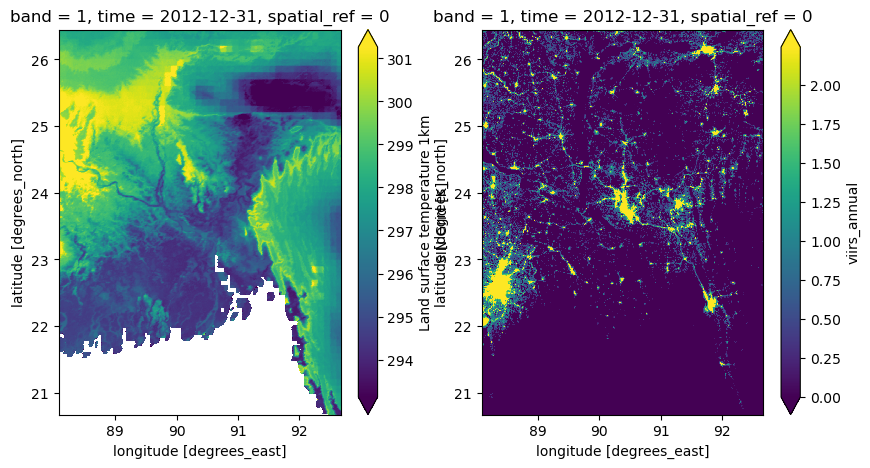

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,5))

modis_bangladesh.sel(time="2012-12-31").ffill("latitude", 2).squeeze().plot.imshow(ax = ax[0], robust=True)
viirs_bangladesh.sel(time="2012-12-31").squeeze().plot.imshow(ax = ax[1], robust=True)

In [6]:
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr")
land_mask = land_mask.rio.write_crs(4326)
land_mask_bangladesh = land_mask.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).land_mask.compute()

In [16]:
def round_coords(ds):
    ds_cp = ds.copy()
    for coord_name in ds_cp.sizes.keys():
        ds_cp.coords[coord_name] = ds_cp.coords[coord_name].values.round(5)
    return ds_cp
    

In [24]:
modis_bangladesh_ld = round_coords(modis_bangladesh.sel(time="2020-12-31") - modis_bangladesh.sel(time="2012-12-31"))

In [18]:
viirs_bangladesh_ld = round_coords(viirs_bangladesh.sel(time="2020-12-31") - viirs_bangladesh.sel(time="2012-12-31"))

In [25]:
merged = xr.merge([modis_bangladesh_ld, viirs_bangladesh_ld], compat='override', join='exact')

In [31]:
merged

<xarray.Dataset> Size: 18MB
Dimensions:       (band: 1, latitude: 1387, longitude: 1102)
Coordinates:
    spatial_ref   int64 8B 0
  * band          (band) int64 8B 1
  * latitude      (latitude) float64 11kB 26.45 26.44 26.44 ... 20.68 20.67
  * longitude     (longitude) float64 9kB 88.08 88.09 88.09 ... 92.67 92.67
Data variables:
    median        (band, latitude, longitude) float64 12MB -0.67 -0.67 ... 0.27
    viirs_annual  (band, latitude, longitude) float32 6MB -0.2089 ... 0.0

In [30]:
merged.plot.countourf()

AttributeError: 'DatasetPlotAccessor' object has no attribute 'countourf'

In [26]:
merged_df = merged.to_dataframe()

<Axes: xlabel='median', ylabel='viirs_annual'>

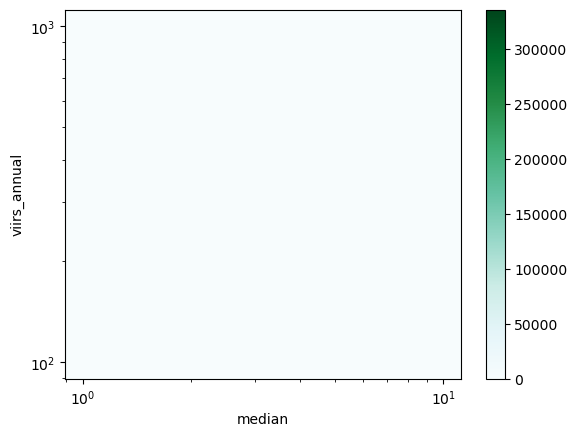

In [ ]:
merged_df.plot(kind="hexbin",x="median",y="viirs_annual")

In [12]:
import seaborn as sns
sns.displot(merged_df, x="median", y="viirs_annual")

: 

: 

: 

In [ ]:
modis_bangladesh_2012 = modis_bangladesh.sel(time="2012-12-31").squeeze()
modis_bangladesh_2012_masked = modis_bangladesh_2012).where(round_coords(land_mask_bangladesh), round_coords(modis_bangladesh_2012))

In [24]:
viirs_bangladesh_2012 = viirs_bangladesh.sel(time="2012-12-31").squeeze()
viirs_bangladesh_2012_masked = round_coords(viirs_bangladesh_2012).where(round_coords(land_mask_bangladesh), round_coords(viirs_bangladesh_2012))

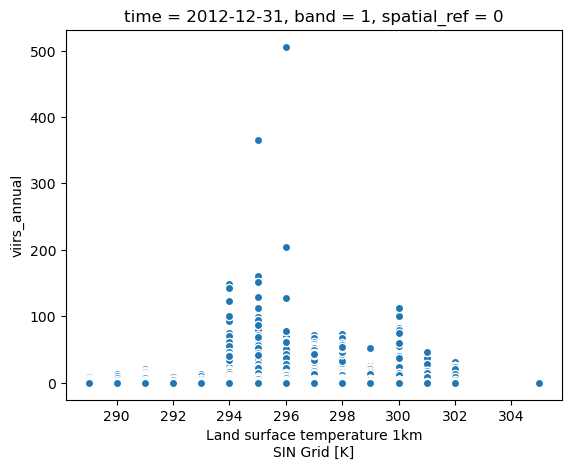

In [30]:
merged.plot.scatter(x="median", y="viirs_annual")

In [23]:
modis_bangladesh_2012_masked

<xarray.Dataset> Size: 104MB
Dimensions:      (latitude: 1387, longitude: 1102)
Coordinates:
    time         datetime64[ns] 8B 2012-12-31
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * latitude     (latitude) float64 11kB 26.45 26.44 26.44 ... 20.68 20.68 20.67
  * longitude    (longitude) float64 9kB 88.08 88.09 88.09 ... 92.66 92.67 92.67
Data variables:
    min          (latitude, longitude) float64 12MB 287.0 287.0 ... 289.0 288.0
    median       (latitude, longitude) float64 12MB 298.0 298.0 ... 294.0 294.0
    max          (latitude, longitude) float64 12MB 306.0 306.0 ... 299.0 299.0
    std          (latitude, longitude) float64 12MB 5.0 5.0 5.0 ... 2.0 2.0 2.0
    rollmin3     (latitude, longitude) float64 12MB 287.0 287.0 ... 290.0 290.0
    mean         (latitude, longitude) float64 12MB 297.0 297.0 ... 294.0 294.0
    valid_count  (latitude, longitude) float32 6MB 365.0 365.0 ... 365.0 365.0
    rollmax3     (latitude, longitude) float64 12MB 306.0 306.0 ... 298.0 298.0
    gt30C        (latitude, longitude) float32 6MB 32.0 32.0 31.0 ... nan nan
    lt0C         (latitude, longitude) float32 6MB nan nan nan ... nan nan nan

In [15]:
modis_bangladesh_2000_masked

<xarray.Dataset> Size: 104MB
Dimensions:      (latitude: 1387, longitude: 1102)
Coordinates:
    time         datetime64[ns] 8B 2000-12-31
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * latitude     (latitude) float64 11kB 26.45 26.44 26.44 ... 20.68 20.68 20.67
  * longitude    (longitude) float64 9kB 88.08 88.09 88.09 ... 92.66 92.67 92.67
Data variables:
    min          (latitude, longitude) float64 12MB 289.4 289.4 ... 288.5 288.5
    median       (latitude, longitude) float64 12MB 298.6 298.7 ... 294.4 294.4
    max          (latitude, longitude) float64 12MB 305.9 305.7 ... 300.0 300.0
    std          (latitude, longitude) float64 12MB 3.48 3.46 3.46 ... 1.99 1.99
    rollmin3     (latitude, longitude) float64 12MB 289.7 289.9 ... 290.1 290.1
    mean         (latitude, longitude) float64 12MB 297.8 297.8 ... 294.4 294.4
    valid_count  (latitude, longitude) float32 6MB 293.0 293.0 ... 292.0 292.0
    rollmax3     (latitude, longitude) float64 12MB 304.9 304.9 ... 298.8 298.8
    gt30C        (latitude, longitude) float32 6MB 9.0 9.0 9.0 ... nan nan nan
    lt0C         (latitude, longitude) float32 6MB nan nan nan ... nan nan nan

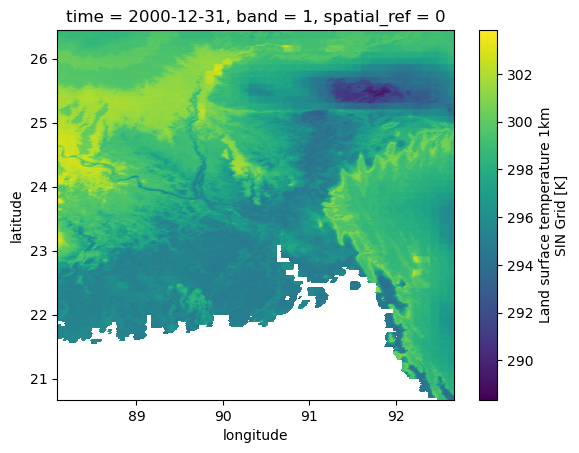

In [14]:
modis_bangladesh_2000_masked["median"].plot.imshow()

In [10]:
modis_bangladesh = modis_bangladesh.where(land_mask_bangladesh)
viirs_bangladesh = viirs_bangladesh.where(land_mask_bangladesh)

In [11]:
(modis_bangladesh["mean"].sel(time = slice("2010-12-31", "2019-12-31")).mean(dim = "time") - 
 modis_bangladesh["mean"].sel(time = slice("2000-12-31", "2009-12-31")).mean(dim = "time")).squeeze().plot.imshow()

TypeError: No numeric data to plot.

/scicore/home/meiera/schulz0022/miniforge-pypy3/envs/gnt/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


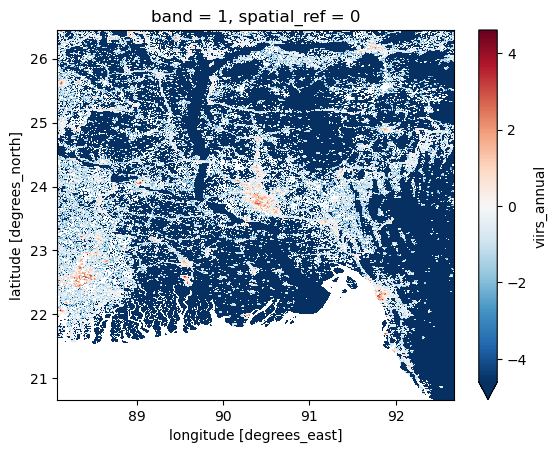

In [7]:
np.log(viirs_bangladesh["viirs_annual"].sel(time = "2020-12-31", band = 1) - viirs_bangladesh["viirs_annual"].sel(time = "2013-12-31", band = 1) + 0.01).plot.imshow(robust = True)

In [8]:
viirs_bangladesh

<xarray.Dataset> Size: 61MB
Dimensions:       (time: 10, band: 1, latitude: 1387, longitude: 1102)
Coordinates:
  * band          (band) int64 8B 1
  * latitude      (latitude) float64 11kB 26.45 26.44 26.44 ... 20.67 20.67
  * longitude     (longitude) float64 9kB 88.08 88.09 88.09 ... 92.67 92.67
  * time          (time) datetime64[ns] 80B 2012-12-31 2013-12-31 ... 2021-12-31
    spatial_ref   int64 8B 0
Data variables:
    viirs_annual  (time, band, latitude, longitude) float32 61MB 0.2089 ... 0.0

In [9]:
merged = xr.combine_by_coords(
    [
        modis_bangladesh["mean"].squeeze(),
        viirs_bangladesh["viirs_annual"].squeeze()
    ],
    combine_attrs="override"
)

In [10]:
merged_df = merged.to_dataframe().dropna()

In [14]:
merged_df

band  spatial_ref   mean  viirs_annual
latitude  longitude time                                              
26.445833 88.083335 2012-12-31     1            0  282.0      0.208900
                    2013-12-31     1            0  282.0      0.000000
                    2014-12-31     1            0  282.0      0.000000
                    2015-12-31     1            0  282.0      0.408697
                    2016-12-31     1            0  282.0      0.000000
...                              ...          ...    ...           ...
20.670833 92.670836 2016-12-31     1            0  293.0      0.000000
                    2017-12-31     1            0  293.0      0.000000
                    2018-12-31     1            0  293.0      0.000000
                    2019-12-31     1            0  294.0      0.000000
                    2020-12-31     1            0  293.0      0.000000

[11019564 rows x 4 columns]

<Axes: xlabel='mean', ylabel='viirs_annual'>

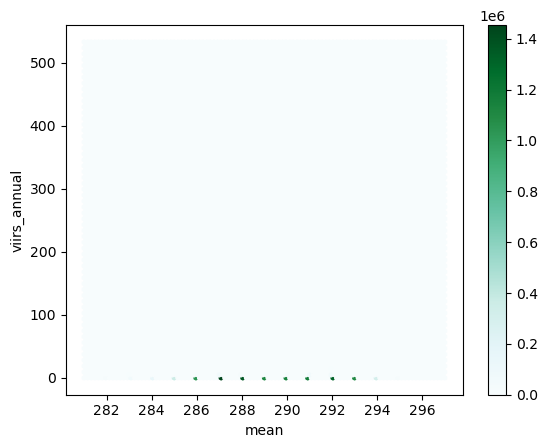

In [13]:
merged_df[["mean", "viirs_annual"]].plot(x = "mean", y = "viirs_annual", kind = "hexbin")

In [24]:
test = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr", consolidated=False)
test = test.rio.write_crs(4326)
test_bangladesh = test.sel(time="2002-12-31")["median"].rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).compute()

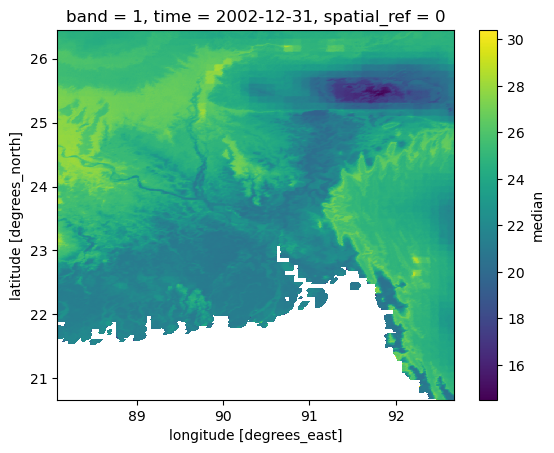

In [36]:
(test_bangladesh - 273.15).squeeze().ffill("latitude", 1).plot.imshow(robust=False)

In [ ]:
#test = test.odc.assign_crs(crs)
# bbox_crs = gpd.GeoSeries([shapely.box(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)], crs=4326).to_crs(crs).bounds.iloc[0]
# test.sel(x=slice(bbox_crs["minx"], bbox_crs["maxx"]), y=slice(bbox_crs["miny"], bbox_crs["maxy"]))["median"].compute().values
bounds = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_1/2002/h08v06.zarr").rio.bounds()

bounds = np.array(bounds).astype(int)
test.sel(x=slice(bbox_crs["minx"], bbox_crs["maxx"]), y=slice(bbox_crs["miny"], bbox_crs["maxy"]))["median"].compute().values
test["max"].sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[1],bounds[3])).compute()#.odc.geobox
test["max"].isel(x=slice(i*1000,(i+1)*1000), y=slice(j*1000,(j+1)*1000)).compute().isnull().mean()